# Tornado Data

My weather variable dataset is located at:
- Latitude: 37.7608
- Longitude: -99.9689

In [34]:
import os
import datetime
import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.colors import BoundaryNorm
from matplotlib.cm import get_cmap
import rasterio
from rasterio.plot import show
from math import radians, cos, sin, asin, sqrt

# Loading in data that we processed
df = pd.read_csv('/Users/evansweeney/Desktop/492_project_local/cmse492_project/data/all_data/KansasStationProcessed.csv', index_col=0, parse_dates=[0])
tornadoes = pd.read_csv('/Users/evansweeney/Desktop/492_project_local/cmse492_project/data/all_data/1950-2021_all_tornadoes.csv')

#### Tornado Dataset variables

- yr - year
- mo - month
- dy - day
- date - date in yyyy-mo-dy format
- time - time in HH:MM:SS format
- tz - timezone
- mag - magnitude (scale used to classify tornadoes based on damage they cause)
    - F0 (65-85 mph): Light damage, including chimneys knocked down, tree branches broken, and roof shingles lost.
    - F1 (86-110 mph): Moderate damage, including roofs peeled off, mobile homes overturned, and foliage and trees damaged.
    - F2 (111-135 mph): Significant damage, including roofs torn off, mobile homes destroyed, and large trees snapped or uprooted.
    - F3 (136-165 mph): Severe damage, including walls collapsed, and entire neighborhoods affected.
    - F4 (166-200 mph): Devastating damage, including well-built homes leveled, and entire communities destroyed.
    - F5 (201-261 mph): Incredible damage, including homes and buildings swept away, and entire neighborhoods obliterated.
- slat - starting latitude
- slon - starting longitude
- elat - ending latitude
- elon - endling longitude
- len - Length in miles

#### Finding tornado stations

In [39]:
url = "https://www.ncei.noaa.gov/oa/global-historical-climatology-network/hourly/doc/ghcnh-station-list.csv"

# Load the CSV into a DataFrame
station_list_df = pd.read_csv(url, on_bad_lines='skip')

# Display the first few rows
# Assign column names
column_names = ['Station ID', 'Latitude', 'Longitude', 'Elevation']

# Slice the DataFrame to include only the first 4 columns
station_list_df = station_list_df.iloc[:, :4]

# Assign the new column names
station_list_df.columns = column_names

# Display the result
print(station_list_df.head())


    Station ID  Latitude  Longitude  Elevation
0  ACM00078861   17.1167   -61.7833       10.0
1  ACU55-00189   18.6000   -63.4700       10.0
2  ACU55-00190   18.6000   -63.4700       12.0
3  ACU55-00191   18.6000   -63.4700       14.0
4  ACU55-00192   18.6000   -63.4700       16.0


In [50]:
### Step 1: Import Necessary Libraries


import pandas as pd
import numpy as np
from itertools import combinations


### Step 2: Define the Haversine Distance Function


# Haversine formula to calculate the distance between two points on the Earth
def haversine(lat1, lon1, lat2, lon2):
    # Earth radius in miles
    R = 3958.8  
    phi1, phi2 = np.radians(lat1), np.radians(lat2)
    d_phi = np.radians(lat2 - lat1)
    d_lambda = np.radians(lon2 - lon1)
    a = np.sin(d_phi / 2.0)**2 + np.cos(phi1) * np.cos(phi2) * np.sin(d_lambda / 2.0)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    return R * c


### Step 3: Prepare Your DataFrame

# Convert Latitude and Longitude to numeric values
station_list_df['Latitude'] = pd.to_numeric(station_list_df['Latitude'], errors='coerce')
station_list_df['Longitude'] = pd.to_numeric(station_list_df['Longitude'], errors='coerce')

# Drop rows with NaN in Latitude or Longitude
station_list_df.dropna(subset=['Latitude', 'Longitude'], inplace=True)

### Step 4: Define Station A's Coordinates


lat_A = 37.7608
lon_A = -99.9689

### Step 5: Calculate Distances from Station A to All Other Stations


# Calculate the distance to Station A for all stations
station_list_df['Distance_to_A'] = station_list_df.apply(
    lambda row: haversine(lat_A, lon_A, row['Latitude'], row['Longitude']), axis=1)


### Step 6: Filter Stations Within 200 Miles of Station A


# Filter stations within 200 miles
stations_within_200 = station_list_df[station_list_df['Distance_to_A'] <= 500].copy()


### Step 7: Generate All Possible Pairs of Stations B and C


# Get the indices of stations within 200 miles
stations_within_200_indices = stations_within_200.index.tolist()

# Generate all possible pairs of Stations B and C
pairs_BC = list(combinations(stations_within_200_indices, 2))

### Step 8: Find Triplets Forming an Equilateral Triangle


# Initialize a list to store results
equilateral_triplets = []

# Set a tolerance level (5%)
tolerance = 0.5

# Loop through each pair of Stations B and C
for idx_B, idx_C in pairs_BC:
    station_B = stations_within_200.loc[idx_B]
    station_C = stations_within_200.loc[idx_C]
    
    # Calculate distances
    dAB = station_B['Distance_to_A']
    dAC = station_C['Distance_to_A']
    dBC = haversine(station_B['Latitude'], station_B['Longitude'], station_C['Latitude'], station_C['Longitude'])
    
    # Calculate the mean distance
    distances = [dAB, dAC, dBC]
    mean_distance = np.mean(distances)
    
    # Compute the maximum deviation from the mean distance
    deviations = [abs(d - mean_distance) for d in distances]
    max_deviation = max(deviations)
    
    # Check if the deviations are within the tolerance
    if max_deviation / mean_distance <= tolerance:
        equilateral_triplets.append({
            'Station_B_ID': station_B['Station ID'],
            'Station_C_ID': station_C['Station ID'],
            'Station_B_Latitude': station_B['Latitude'],
            'Station_B_Longitude': station_B['Longitude'],
            'Station_C_Latitude': station_C['Latitude'],
            'Station_C_Longitude': station_C['Longitude'],
            'Distance_AB': dAB,
            'Distance_AC': dAC,
            'Distance_BC': dBC,
            'Mean_Distance': mean_distance,
            'Max_Deviation_Percentage': (max_deviation / mean_distance) * 100
        })


### Step 9: Convert Results to a DataFrame and View


# Convert the results to a DataFrame
equilateral_df = pd.DataFrame(equilateral_triplets)

# Sort by Mean_Distance to find triplets within your desired distance range (50 to 200 miles)
equilateral_df = equilateral_df[(equilateral_df['Mean_Distance'] >= 50) & (equilateral_df['Mean_Distance'] <= 500)]
equilateral_df.sort_values(by='Mean_Distance', inplace=True)

# View the results
print(equilateral_df.head())

  Station_B_ID Station_C_ID  Station_B_Latitude  Station_B_Longitude  \
0  USW00033024  USW00043056                36.5                -98.5   
1  USW00043056  USW00053087                39.0                -97.0   

   Station_C_Latitude  Station_C_Longitude  Distance_AB  Distance_AC  \
0                39.0                -97.0   118.892361   182.165424   
1                34.5                -95.0   182.165424   357.185844   

   Distance_BC  Mean_Distance  Max_Deviation_Percentage  
0   191.180035     164.079273                 27.539683  
1   330.024003     289.791757                 37.139198  


In [55]:
import pandas as pd

# Assuming station_list_df is your existing DataFrame

# Define the list of Station_IDs to filter
station_ids = ['USW00033024', 'USW00043056', 'USW00013985']

# Filter the DataFrame
filtered_df = station_list_df[station_list_df['Station ID'].isin(station_ids)]

# Print the filtered rows
print(filtered_df)



    Station ID  Latitude  Longitude    Distance  Distance_to_A
0  USW00013985   37.7608   -99.9689    0.000000       0.000000
2  USW00033024   36.5000   -98.5000  118.897023     118.892361
3  USW00043056   39.0000   -97.0000  182.437107     182.165424


In [27]:
# columns I'll be using
selected_columns = ['yr', 'mo', 'dy', 'date', 'time', 'tz', 'mag', 'slat', 'slon', 'elat', 'elon', 'len']
tornadoes = tornadoes[selected_columns]

# getting my pandas datetime
tornadoes['Datetime'] = pd.to_datetime(tornadoes['date'] + ' ' + tornadoes['time'])

# placing datetime as 1st column for convience
cols = ['Datetime'] + [col for col in tornadoes.columns if col != 'Datetime']
tornadoes = tornadoes[cols]

# same year selection as my weather dataset, 2011 to 2016
tornadoes = tornadoes[(tornadoes['yr'] >= 2011) & (tornadoes['yr'] <= 2016)]

# won't need these anymore
tornadoes = tornadoes.drop(columns=['yr', 'mo', 'dy', 'tz', 'date', 'time'])


In [56]:
# find average lat and long of each tornado based on starting latitude/longitude and ending latitude/longitude
tornadoes['lat'] = (tornadoes['slat'] + tornadoes['elat']) / 2
tornadoes['long'] = (tornadoes['slon'] + tornadoes['elon']) / 2

tornadoes.drop(columns=['slat', 'slon', 'elat', 'elon'], inplace=True)

def haversine(lat1, lon1, lat2, lon2):
    """
    Calculate the great-circle distance between two points on the Earth.
    """
    # decimal degrees to radians
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # The haversine formula
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    r = 3956  # radius of earth
    return c * r

# my weather stations coordinates
station_lat = 37.7608
station_lon = -99.9689

# applying distance to weather station function
tornadoes['distance_to_station'] = tornadoes.apply(
    lambda row: haversine(station_lat, station_lon, row['lat'], row['long']), axis=1)

# only keeping tornado instances that are ~70 miles to my weather station
tornadoes = tornadoes[tornadoes['distance_to_station'] <= 400]

tornadoes.reset_index(drop=True, inplace=True)

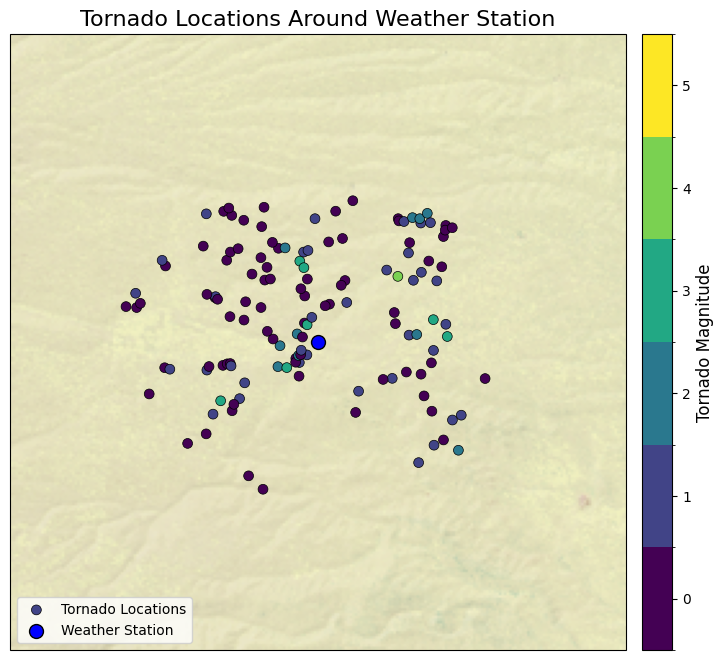

In [29]:
stations = {
    'Station 1': {'lat': 37.7608, 'lon': -99.9689},
    'Station 2': {'lat': 36.5000, 'lon': -98.5000},
    'Station 3': {'lat': 39.0000, 'lon': -97.0000}
}

lats = tornadoes['lat']
lons = tornadoes['long']
mags = tornadoes['mag']

# Set the extent for a ~ 70-mile radius
extent_margin = 2
lat_min = station_lat - extent_margin
lat_max = station_lat + extent_margin
lon_min = station_lon - extent_margin
lon_max = station_lon + extent_margin

# 
raster_path = '/Users/evansweeney/Desktop/492_project_local/cmse492_project/data/all_data/NE1_HR_LC_SR.tif'

# creating the map
fig = plt.figure(figsize=(10, 8))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())

with rasterio.open(raster_path) as src:
    show(src, ax=ax, transform=ccrs.PlateCarree())

# ax.add_feature(cfeature.LAND, facecolor=cfeature.COLORS['land'])

# Define the colormap and normalization
cmap = plt.get_cmap('viridis', 6)  # 6 discrete colors for magnitudes 0 to 5
bounds = np.linspace(-0.5, 5.5, 7)  # Bounds for magnitudes from -0.5 to 5.5
norm = BoundaryNorm(bounds, cmap.N)

# Plot tornado locations with color corresponding to magnitude
scatter = ax.scatter(
    lons,
    lats,
    c=mags,
    cmap=cmap,
    norm=norm,
    s=50,
    edgecolor='k',
    linewidth=0.5,
    transform=ccrs.PlateCarree(),
    label='Tornado Locations'
)

# Add colorbar with ticks at integer magnitudes
cbar = plt.colorbar(
    scatter,
    ax=ax,
    orientation='vertical',
    pad=0.02,
    ticks=range(0, 6)
)
cbar.set_label('Tornado Magnitude', fontsize=12)

# Plot weather station location
ax.scatter(
    station_lon,
    station_lat,
    color='blue',
    s=100,
    edgecolor='k',
    linewidth=1,
    transform=ccrs.PlateCarree(),
    label='Weather Station'
)

# Add title and legend
plt.title('Tornado Locations Around Weather Station', fontsize=16)
plt.legend(loc='lower left')
plt.show()


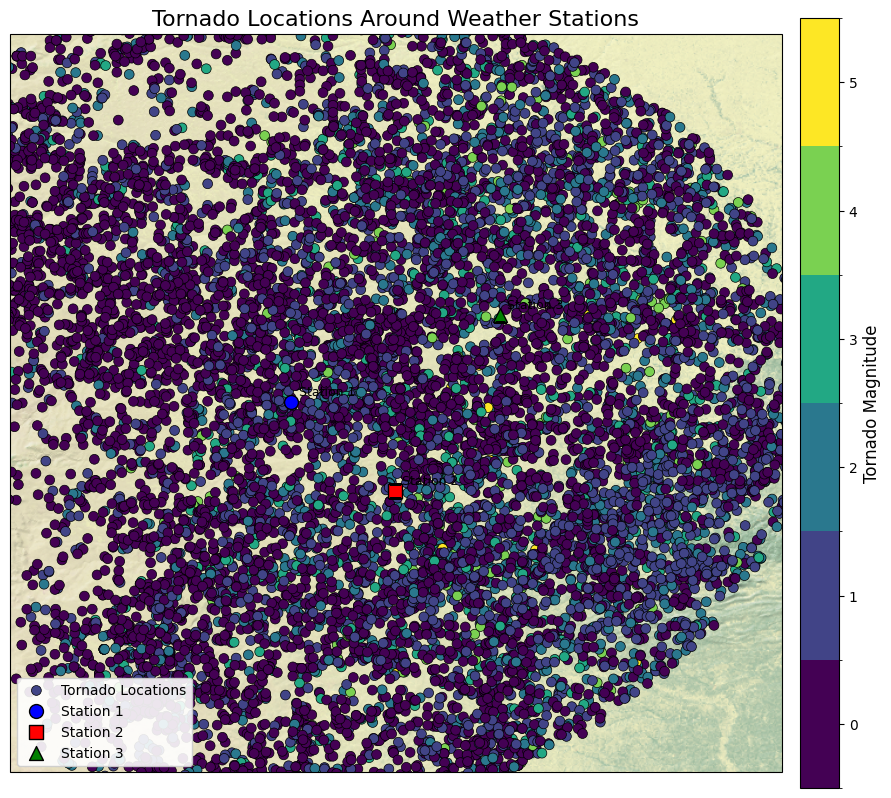

In [58]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import rasterio
from rasterio.plot import show
import numpy as np
from matplotlib.colors import BoundaryNorm

# Define the coordinates of all three weather stations
stations = {
    'Station 1': {'lat': 37.7608, 'lon': -99.9689},
    'Station 2': {'lat': 36.5000, 'lon': -98.5000},
    'Station 3': {'lat': 39.0000, 'lon': -97.0000}
}

# Extract all latitudes and longitudes from the stations
station_lats = [info['lat'] for info in stations.values()]
station_lons = [info['lon'] for info in stations.values()]

# Define the extent margin in degrees (approximately 2 degrees ~ 140 miles)
extent_margin = 4

# Calculate the overall min and max latitude and longitude
lat_min = min(station_lats) - extent_margin
lat_max = max(station_lats) + extent_margin
lon_min = min(station_lons) - extent_margin
lon_max = max(station_lons) + extent_margin

# Load tornado data
lats = tornadoes['lat']
lons = tornadoes['long']
mags = tornadoes['mag']

# Path to the raster file
raster_path = '/Users/evansweeney/Desktop/492_project_local/cmse492_project/data/all_data/NE1_HR_LC_SR.tif'

# Create the map
fig = plt.figure(figsize=(12, 10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())

# Add raster data to the map
with rasterio.open(raster_path) as src:
    show(src, ax=ax, transform=ccrs.PlateCarree())

# Optional: Add land feature for better visualization
ax.add_feature(cfeature.LAND, facecolor=cfeature.COLORS['land'])

# Define the colormap and normalization for tornado magnitudes
cmap = plt.get_cmap('viridis', 6)  # 6 discrete colors for magnitudes 0 to 5
bounds = np.linspace(-0.5, 5.5, 7)  # Bounds for magnitudes from -0.5 to 5.5
norm = BoundaryNorm(bounds, cmap.N)

# Plot tornado locations with color corresponding to magnitude
scatter = ax.scatter(
    lons,
    lats,
    c=mags,
    cmap=cmap,
    norm=norm,
    s=50,
    edgecolor='k',
    linewidth=0.5,
    transform=ccrs.PlateCarree(),
    label='Tornado Locations'
)

# Add colorbar with ticks at integer magnitudes
cbar = plt.colorbar(
    scatter,
    ax=ax,
    orientation='vertical',
    pad=0.02,
    ticks=range(0, 6)
)
cbar.set_label('Tornado Magnitude', fontsize=12)

# Define distinct markers and colors for each station
station_markers = ['o', 's', '^']  # Circle, square, triangle
station_colors = ['blue', 'red', 'green']

# Plot each weather station
for idx, (station_name, coords) in enumerate(stations.items()):
    ax.scatter(
        coords['lon'],
        coords['lat'],
        color=station_colors[idx],
        marker=station_markers[idx],
        s=100,
        edgecolor='k',
        linewidth=1,
        transform=ccrs.PlateCarree(),
        label=station_name
    )
    # Optionally, add labels next to each station
    ax.text(
        coords['lon'] + 0.1,  # Slight offset to the east
        coords['lat'] + 0.1,  # Slight offset to the north
        station_name,
        fontsize=9,
        transform=ccrs.PlateCarree()
    )

# Add title and legend
plt.title('Tornado Locations Around Weather Stations', fontsize=16)
plt.legend(loc='lower left', fontsize=10, markerscale=1, framealpha=0.9)

# Show the plot
plt.show()


In [30]:
print(df.columns)

Index(['temperature', 'dew_point_temperature', 'wet_bulb_temperature',
       'station_level_pressure', 'sea_level_pressure', 'wind_gust',
       'relative_humidity', 'precipitation', 'visibility', 'sky_cover',
       'sky_cover_baseht', 'Wx', 'Wy', 'Day sin', 'Day cos', 'Year sin',
       'Year cos'],
      dtype='object')


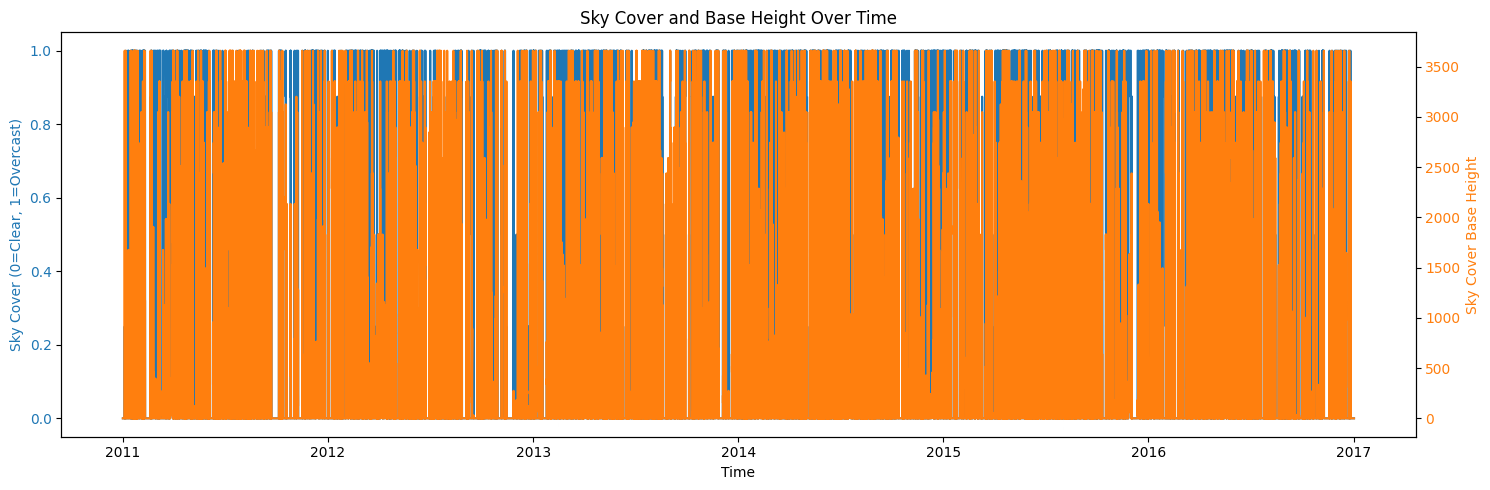

In [32]:
fig, ax1 = plt.subplots(figsize=(15, 5))

# Plot 'sky_cover' on the first y-axis
color = 'tab:blue'
ax1.set_xlabel('Time')
ax1.set_ylabel('Sky Cover (0=Clear, 1=Overcast)', color=color)
ax1.plot(df.index, df['sky_cover'], color=color, label='Sky Cover')
ax1.tick_params(axis='y', labelcolor=color)

# Create a second y-axis for 'sky_cover_baseht'
ax2 = ax1.twinx()
color = 'tab:orange'
ax2.set_ylabel('Sky Cover Base Height', color=color)
ax2.plot(df.index, df['sky_cover_baseht'], color=color, label='Sky Cover Base Height')
ax2.tick_params(axis='y', labelcolor=color)

# Add a title and adjust layout
plt.title('Sky Cover and Base Height Over Time')
fig.tight_layout()
plt.show()



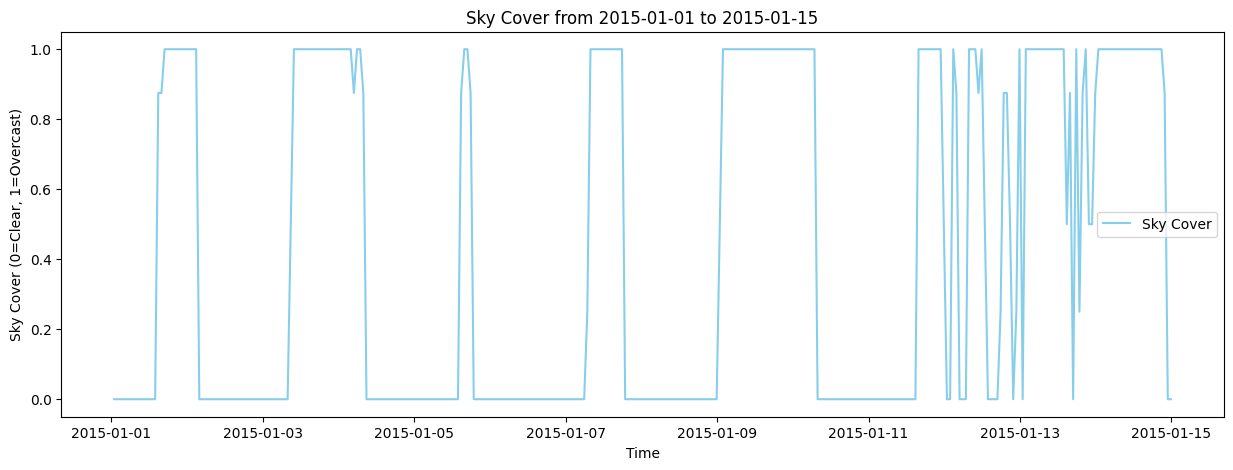

In [33]:
# Define the time range
start_date = '2015-01-01'
end_date = '2015-01-15'

# Create a mask for the date range
mask = (df.index >= start_date) & (df.index <= end_date)
df_subset = df.loc[mask]

# Plot 'sky_cover' over the specified time range
plt.figure(figsize=(15, 5))
plt.plot(df_subset.index, df_subset['sky_cover'], label='Sky Cover', color='skyblue')
plt.title(f'Sky Cover from {start_date} to {end_date}')
plt.xlabel('Time')
plt.ylabel('Sky Cover (0=Clear, 1=Overcast)')
plt.legend()
plt.show()
